In [8]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import cascaded_union
import shapely.wkt
from shapely.validation import explain_validity,make_valid
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path
from timezonefinder import TimezoneFinder
import pytz
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})

In [3]:
incidents_all = pd.read_csv('unique_fires.csv')
incidents_all = pd.concat([incidents_all, pd.DataFrame({'First Day UTC': np.zeros(len(incidents_all)),\
                                                'Last Day UTC': np.zeros(len(incidents_all)),\
                                               'Timezone': np.zeros(len(incidents_all))})], axis=1)
incidents_all['Fire Name'] = incidents_all['Fire Name'].str.upper() # make all fire names upper case so they can be easily searched

#put incident timezones into UTC
#NEED TO DEAL WITH TIME ZONES, based on location and time of year, from here: https://pypi.org/project/pytz/
for ii in range(len(incidents_all)):
    obj=TimezoneFinder() #initialize the timezone finder
    tz = obj.timezone_at(lng=incidents_all['Lon Fire'].iloc[ii], lat=incidents_all['Lat Fire'].iloc[ii]) #get the timezone
    
    local = pytz.timezone(tz)
    utc = pytz.utc
    #put the start and end times in local time
    loc_dt_start = local.localize(datetime.strptime(incidents_all['First Day'].iloc[ii], '%Y-%m-%d %H:%M:%S'))
    loc_dt_end = local.localize(datetime.strptime(incidents_all['Last Day'].iloc[ii], '%Y-%m-%d'))
    #put them in UTC time
    utc_dt_start = loc_dt_start.astimezone(utc)
    utc_dt_end = loc_dt_end.astimezone(utc)
        
    #reassign to UTC time, this DOES keep track of daylight savings (eg +7 is used for PDT, +8 is used for PST)
    incidents_all['First Day UTC'].iloc[ii] = str(utc_dt_start)[0:19]
    incidents_all['Last Day UTC'].iloc[ii] = str(utc_dt_end)[0:19]
    incidents_all['Timezone'].iloc[ii] = tz    
incidents_all

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,First Day UTC,Last Day UTC,Timezone
0,10662156.0,C34,2019-02-13 15:00:00,2019-02-15,36.995278,-102.524722,2019-02-13 22:00:00,2019-02-15 07:00:00,America/Denver
1,10662179.0,2161,2019-02-13 16:40:00,2019-02-14,35.221389,-101.518611,2019-02-13 22:40:00,2019-02-14 06:00:00,America/Chicago
2,10662684.0,PAINTED WAGON,2019-04-08 13:02:00,2019-04-10,33.786944,-112.753333,2019-04-08 20:02:00,2019-04-10 07:00:00,America/Phoenix
3,10663171.0,LONE MOUNTAIN,2019-05-26 23:56:00,2019-07-03,33.808056,-105.738611,2019-05-27 05:56:00,2019-07-03 06:00:00,America/Denver
4,10663525.0,BOULDER,2019-06-05 12:45:00,2019-06-06,35.333056,-119.905556,2019-06-05 19:45:00,2019-06-06 07:00:00,America/Los_Angeles
...,...,...,...,...,...,...,...,...,...
1350,11979081.0,LAURA 2,2020-11-17 13:30:00,2020-11-23,40.034034,-120.115073,2020-11-17 21:30:00,2020-11-23 08:00:00,America/Los_Angeles
1351,11979237.0,TRAIL,2020-10-24 21:32:00,2020-11-02,34.147222,-112.117778,2020-10-25 04:32:00,2020-11-02 07:00:00,America/Phoenix
1352,11980186.0,SANDERSON,2020-12-13 03:00:00,2020-12-14,33.889444,-117.070833,2020-12-13 11:00:00,2020-12-14 08:00:00,America/Los_Angeles
1353,11980587.0,CREEK 5,2020-12-24 01:22:00,2020-12-28,33.402646,-117.266795,2020-12-24 09:22:00,2020-12-28 08:00:00,America/Los_Angeles


In [113]:
incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,First Day UTC,Last Day UTC,Timezone
1088,11843929.0,AUGUST COMPLEX,2020-08-17 13:44:00,2020-11-11,39.659444,-122.808889,2020-08-17 20:44:00,2020-11-11 08:00:00,America/Los_Angeles


In [10]:
fire_incidents = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH', 'WILLIAMS FLATS', 'SHADY','PEDRO MOUNTAIN', 'WALKER', '204 COW']
inci_choose = [0,1,0,0,2,2,0,0,0,0,0,0,0] #choose which fire when there are multiple (need to automate)

#fire_incidents = ['CREEK', 'WILLIAMS FLATS']#, 'LAKE', 'CAMERON PEAK', 'PINE GULCH']
#inci_choose = [2,0]#,2,0,0] #choose which fire when there are multiple (need to automate)
#fire_incidents = ['LAKE']
#inci_choose =[2]

for ii in range(len(fire_incidents)):
    
    print(fire_incidents[ii])
    """
    inci = incidents_all[incidents_all['Fire Name']==fire_incidents[ii]].iloc[inci_choose[ii]]
    print(inci)
    df_save_size = count_overpasses(inci,viirs_all) #count the overpasses between fire start and end date
    print(df_save_size)
    
    fire_poly_timeseries = build_polygon_timeseries(df_save_size,inci)
    
    fire_poly_timeseries.crs = "EPSG:4326"
    fire_poly_timeseries = fire_poly_timeseries.to_crs(epsg=3347) #put into lambert conformal conic
    
    #make sure the returned polygons are valid
    fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].buffer(0)
    fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))
    fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda y: make_valid(y))
    fire_poly_timeseries['geometry'].apply(lambda z: print(explain_validity(z)))
    
    
    #fig = plt.figure(figsize=(15,10))
    #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    ##ax.set_extent([-124, -122, 39.2,40.5])
    #fire_poly_timeseries.plot(column = fire_poly_timeseries['DateTime'], ax=ax, cmap='OrRd')
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
    #                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #gl.top_labels = False
    #gl.right_labels = False
    #plt.title(fire_incidents[ii]+ 'With Per Overpass Polygons')
    #plt.show()
    
    fire_poly_timeseries.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    #fire_poly_timeseries.to_file(fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_per_overpass_2.geojson', driver='GeoJSON')
    """
    day_start_hour =0
    daily_fire_att_poly = combine_per_overpass_polygons_to_daily(fire_incidents[ii],day_start_hour)
    daily_fire_att_poly.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    print(daily_fire_att_poly)
    daily_fire_att_poly.to_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+
                                '_VIIRS_daily_'+str(day_start_hour)+'Z_day_start.geojson', driver='GeoJSON')

AUGUST COMPLEX
['2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-29', '2020-08-29', '202

25 seconds
     Local Day                                           geometry  \
0   2020-09-06  MULTIPOLYGON (((3663338.756 254898.573, 366332...   
1   2020-09-07  MULTIPOLYGON (((3665744.958 253363.469, 366573...   
2   2020-09-08  MULTIPOLYGON (((3663935.789 250656.656, 366393...   
3   2020-09-09  MULTIPOLYGON (((3670387.970 251690.940, 367039...   
4   2020-09-10  MULTIPOLYGON (((3661166.868 250662.223, 366115...   
5   2020-09-11  MULTIPOLYGON (((3662951.584 249718.150, 366296...   
6   2020-09-12  MULTIPOLYGON (((3661460.620 248678.278, 366145...   
7   2020-09-13  MULTIPOLYGON (((3663819.908 248568.460, 366381...   
8   2020-09-14  MULTIPOLYGON (((3658327.864 253837.970, 365831...   
9   2020-09-15  MULTIPOLYGON (((3671239.711 251191.701, 367122...   
10  2020-09-16  MULTIPOLYGON (((3658317.420 257986.419, 365830...   
11  2020-09-17  MULTIPOLYGON (((3672509.222 250276.600, 367250...   
12  2020-09-18  MULTIPOLYGON (((3684850.380 265718.366, 368483...   
13  2020-09-19  MULTIPO

DOLAN
['2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-28', '2020-08-29', '2020-08-29', '2020-08-29', '2020-08-29', '2020-08-29', '2020-08-29', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-31', '2020-08-31', '2020-08-31', '2020-08-31', '2020-08-31', '2020-08-31',

HOLIDAY FARM
['2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-17', '2020-09-17', '2020-09-17', '2020-09-17', '2020-09-17', '2020-09-17', '2020-09-18', '2020-09-23', '2020-09-29', '2020-10-04', '2020-10-06', '2020-10-07', '2020-

96 seconds
     Local Day                                           geometry  \
0   2020-09-05  MULTIPOLYGON (((3692327.427 626593.064, 369233...   
1   2020-09-06  MULTIPOLYGON (((3686865.964 627056.485, 368685...   
2   2020-09-07  MULTIPOLYGON (((3696821.413 632900.284, 369682...   
3   2020-09-08  MULTIPOLYGON (((3682401.899 609276.866, 368239...   
4   2020-09-09  MULTIPOLYGON (((3683015.165 611130.459, 368301...   
..         ...                                                ...   
66  2020-12-07  POLYGON ((3725128.727 657571.381, 3725118.197 ...   
67  2020-12-11  POLYGON ((3687654.495 637528.473, 3687638.544 ...   
68  2020-12-15  POLYGON ((3694741.948 611082.227, 3694732.724 ...   
69  2020-12-18  POLYGON ((3674964.249 645151.812, 3674954.941 ...   
70  2020-12-19  POLYGON ((3687198.260 637700.830, 3687191.702 ...   

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11908866.0     CREEK  2020-09-05            2118.0  37.201111   
1        119

64 seconds
     Local Day                                           geometry  \
0   2020-08-13  MULTIPOLYGON (((4983208.790 611162.448, 498320...   
1   2020-08-14  MULTIPOLYGON (((4976803.522 612504.223, 497679...   
2   2020-08-15  MULTIPOLYGON (((4977129.329 611986.859, 497712...   
3   2020-08-16  MULTIPOLYGON (((4982134.668 616393.999, 498212...   
4   2020-08-17  MULTIPOLYGON (((4974176.642 609908.568, 497416...   
..         ...                                                ...   
60  2020-10-20  MULTIPOLYGON (((5024283.580 586245.245, 502428...   
61  2020-10-21  MULTIPOLYGON (((5023279.333 586933.098, 502327...   
62  2020-10-22  MULTIPOLYGON (((5014881.017 588119.975, 501487...   
63  2020-10-24  MULTIPOLYGON (((4993823.459 581391.141, 499381...   
64  2020-11-06  POLYGON ((4996785.197 602616.664, 4996784.563 ...   

    Incident Number     Fire Name Current Day  Current Overpass   Lat Fire  \
0        11856938.0  CAMERON PEAK  2020-08-13            2100.0  40.608611   
1   

WILLIAMS FLATS
['2019-08-02', '2019-08-02', '2019-08-02', '2019-08-03', '2019-08-03', '2019-08-03', '2019-08-03', '2019-08-04', '2019-08-04', '2019-08-04', '2019-08-05', '2019-08-05', '2019-08-05', '2019-08-05', '2019-08-06', '2019-08-06', '2019-08-06', '2019-08-06', '2019-08-07', '2019-08-07', '2019-08-07', '2019-08-08', '2019-08-08', '2019-08-08', '2019-08-08', '2019-08-09', '2019-08-10', '2019-08-18']
1 seconds
    Local Day                                           geometry  \
0  2019-08-02  MULTIPOLYGON (((4252352.505 1725733.914, 42523...   
1  2019-08-03  MULTIPOLYGON (((4256664.879 1723929.755, 42566...   
2  2019-08-04  MULTIPOLYGON (((4253501.471 1729904.695, 42534...   
3  2019-08-05  MULTIPOLYGON (((4261021.565 1723600.789, 42610...   
4  2019-08-06  MULTIPOLYGON (((4262340.085 1722311.660, 42623...   
5  2019-08-07  MULTIPOLYGON (((4267220.165 1719823.290, 42672...   
6  2019-08-08  MULTIPOLYGON (((4268578.208 1718150.764, 42685...   
7  2019-08-09  MULTIPOLYGON (((4266531

PEDRO MOUNTAIN
['2019-08-24', '2019-08-24', '2019-08-24', '2019-08-25', '2019-08-25', '2019-08-26', '2019-08-26', '2019-08-26', '2019-08-27', '2019-08-27', '2019-08-28', '2019-08-28', '2019-08-28', '2019-08-29', '2019-08-29', '2019-08-29', '2019-08-30', '2019-08-30', '2019-08-30', '2019-08-31', '2019-08-31', '2019-08-31', '2019-09-01', '2019-09-01', '2019-09-01', '2019-09-02', '2019-09-02', '2019-09-02', '2019-09-03', '2019-09-03', '2019-09-04']
0 seconds
     Local Day                                           geometry  \
0   2019-08-24  MULTIPOLYGON (((4935122.137 828424.839, 493511...   
1   2019-08-25  MULTIPOLYGON (((4938771.396 827345.972, 493876...   
2   2019-08-26  MULTIPOLYGON (((4944478.576 825791.867, 494447...   
3   2019-08-27  MULTIPOLYGON (((4936624.300 825352.936, 493661...   
4   2019-08-28  MULTIPOLYGON (((4936462.084 824758.628, 493645...   
5   2019-08-29  MULTIPOLYGON (((4939830.032 830513.587, 493982...   
6   2019-08-30  MULTIPOLYGON (((4938834.741 821920.400, 4

In [7]:

#make total polygons using dissolve
fire_incidents = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH', 'WILLIAMS FLATS', 'SHADY','PEDRO MOUNTAIN', 'WALKER', '204 COW']
inci_choose = [0,1,0,0,2,2,0,0,0,0,0,0,0] #choose which fire when there are multiple (need to automate)

#fire_incidents = ['LAKE']
#inci_choose =[2]

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    daily_fire_poly = gpd.read_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_daily.geojson')
    
    tic=time.time()
    total_fire_poly = daily_fire_poly.dissolve(by='Fire Name')
    toc=time.time()
    print(toc-tic)
    total_fire_poly.to_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_total.geojson', driver='GeoJSON')

AUGUST COMPLEX
36419.20762300491
BOBCAT
962.5314848423004
DOLAN
865.6063847541809
HOLIDAY FARM
3081.2354674339294
CREEK
15650.018680095673
LAKE
40.24928617477417
CAMERON PEAK
1335.49036693573
PINE GULCH
662.7405762672424
WILLIAMS FLATS
5.877187490463257
SHADY
0.5850832462310791
PEDRO MOUNTAIN
0.1937863826751709
WALKER
18.841508626937866
204 COW
0.7579379081726074


In [5]:
#function to get the size of the resulting dataframe
#IN: incidents=the summary table of the incidents (only one incident at a time)
#IN: viirs_all= table of all VIIRS detects
#OUT: df_size= the number of satellite overpasses between start and end times of fire in UTC
def count_overpasses(incidents,viirs_all):
    df_size = 0
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'],'D') 

    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                    & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
    return df_size

In [6]:
def build_polygon_timeseries(df_size,incidents):
    fire_series_new = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe

    fire_series_cumu = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of TOTAL VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
    count = 0
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'], 'D') 
    
    lat_fire = incidents['Lat Fire']
    lon_fire = incidents['Lon Fire']
    print(lon_fire, lat_fire)
    
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    #name = incidents['Fire Name']
    #print(name)
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    print(dates)
    
    tic=np.datetime64('now') #to time how long the code takes
   
    for day in dates: #loop over the days
        print(day)
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        
        for over in overpasses: #loop over the overpasses
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
    
            poly_lats, poly_lons = build_today_polygon(lat, lon, lat_old, lon_old, 0.1)
        
            #get the new points and the cumulative points
            #poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
            poly_tups_new = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lons))]
            
            
            if day==dates[0] and over==overpasses[0]: #if it's the first day of the fire
                #get the cumulative stuff 
                lat_cumulative = np.append(lat_old, poly_lats)
                lon_cumulative = np.append(lon_old, poly_lons)
                poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                #make a shape around the cumulative points, buffer by 300m (0.0027027 degrees ~0.003 degrees) NEED TO DIVIDE BY 2
                shape_new_save = MultiPoint(poly_tups_cumulative).buffer(0.001763092448)#.convex_hull #the full shape so far
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over,\
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]     
                    
                count=count+1
                
            elif len(poly_tups_new)!=0: #if we are adding new points
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_new] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                shape_new = MultiPoint(poly_tups_new).buffer(0.001763092448)
                shape_cumu = fire_series_cumu['geometry'].iloc[count-1]
                shape_new_save = shape_new.difference(shape_cumu)
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over,  \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new.union(shape_cumu)]     
                    
                count=count+1
                
            lat_cumulative = np.append(lat_old, poly_lats)
            lon_cumulative = np.append(lon_old, poly_lons)
            lat_old=lat_cumulative
            lon_old=lon_cumulative
            
    
    toc = np.datetime64('now') #to time how long the code takes
    print(str(toc-tic)+' seconds elapsed')
    
    #drop null geometries
    fire_series_new = fire_series_new.drop(np.where(fire_series_new['geometry']==None)[0])

    return fire_series_new

In [7]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(lats, lons, lats_old, lons_old, bf):
    tups_old = [list((lons_old[i], lats_old[i])) for i in range(len(lats_old))]
    shape_old_buff = MultiPoint(tups_old).convex_hull.buffer(bf)
    #find the points that are inside the buffer
    pairs = zip(lons, lats)
    lat_new = []
    lon_new = []
    
    xs, ys = shape_old_buff.exterior.xy #get the edges of the buffered shape
    poly_path = Path(np.stack([xs, ys], axis=1)) #make them into a path
    poly_path_contains = poly_path.contains_points(np.stack([lons,lats],axis=1)) #get the points that are in the shape REPLACES FOR LOOP
    #grab the new points
    lat_new =lats[np.where(poly_path_contains==True)[0]]
    lon_new =lons[np.where(poly_path_contains==True)[0]]

        
    if (len(lat_new)-len(lats_old))>0: #if we are adding points 
        #print('Time for recursive call')
        return build_today_polygon(lats, lons, lat_new, lon_new, bf)
    else:
        return lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON
    

In [9]:
#uses max to combine the polygons, day starts at day_start_hour
def combine_per_overpass_polygons_to_daily(fire, day_start_hour):
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file('./fire_polygons/'+fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only

    daystrings = [per_overpass_fire['Current Day'].iloc[i]  for i in range(len(per_overpass_fire))]
    timestrings = [str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(per_overpass_fire))]

    datetime_strings = [daystrings[i]+'T'+timestrings[i][0:2]+':'+timestrings[i][2:4] for i in range(len(per_overpass_fire))]
    datetimes = np.array(datetime_strings,dtype='datetime64')

    current_day = [] #if observed hour>day_start_hour, current day, else previous day
    for ii in range(len(datetimes)):
        time_compare = np.datetime64(daystrings[ii]+'T'+str(day_start_hour).zfill(2)+':00')
        if datetimes[ii]>= time_compare:
            current_day.append(daystrings[ii])
        else:
            current_day.append(str(np.datetime64(daystrings[ii])-np.timedelta64(1,'D')))
    print(current_day)
    per_overpass_fire['Local Day'] = current_day
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Local Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

## Testing

In [17]:
fire = 'LAKE'
fire_daily = combine_per_overpass_polygons_to_daily(fire,12)
print(fire_daily)

['2020-08-12', '2020-08-12', '2020-08-12', '2020-08-13', '2020-08-13', '2020-08-13', '2020-08-14', '2020-08-14', '2020-08-14', '2020-08-14', '2020-08-14', '2020-08-14', '2020-08-15', '2020-08-15', '2020-08-15', '2020-08-15', '2020-08-15', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-29']
1 seconds
     Local Day                                           geometry  \
0   2020-08-12  MULTIPOLYGON (((3641986.585 323212.339, 364197...   
1   2020-08-13  MULTIPOLYGON (((3630083.512 322187.932, 363007...   
2   2020-08-

In [6]:
#uses max to combine the polygons
def combine_per_overpass_polygons_to_daily_old(fire):
    print(fire.upper(), fire.lower())
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file(fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only
    fire_inds = np.where(per_overpass_fire['Fire Name']==fire.upper())[0];
    
    datestrings = [per_overpass_fire['Current Day'].iloc[i]+ ' '+\
               str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(fire_inds))]
    
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Current Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

<AxesSubplot:>

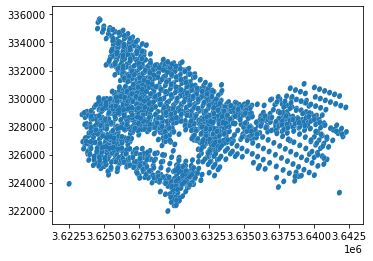

In [10]:
df_lake_new = gpd.read_file('lake_VIIRS_per_overpass_2.geojson')
df_lake_new.plot()

<AxesSubplot:>

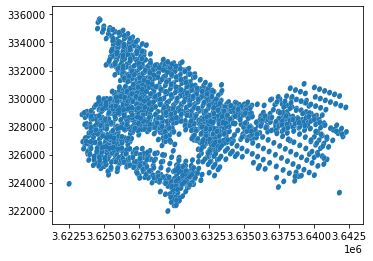

In [11]:
df_lake= gpd.read_file('./fire_polygons/lake_VIIRS_per_overpass.geojson')
df_lake.plot()